# Skip Gram

先准备句子，进行分词，形成词汇表

In [1]:
# sentences = [
#     "The New York Times is a daily newspaper based in New York City",
#     "The effort failed once local California newspapers came into prominence",
#     "Shortly after assuming control of the paper Ochs coined the paper slogan"
# ]
# sentences = [
#     "Kage is Teacher",
#     "Niuzong is Boss",
#     "Mazong is Boss",
#     "Xiaoxue is Student",
#     "Xiaobing is Student"
# ]
sentences = [
    "Cat is animal","Dog is animal","Lion is animal","Merlin is bird","Pidgin is bird"
]
words = list(set((' '.join(sentences)).split()))
print(f"words :{words}")
print(f"vocabular size:{len(words)}")

words :['bird', 'Cat', 'Lion', 'is', 'Pidgin', 'Merlin', 'Dog', 'animal']
vocabular size:8


映射一个 word => index 的列表

In [2]:
word_to_idx = {word:idx for idx,word in enumerate(words)}
print(word_to_idx)

{'bird': 0, 'Cat': 1, 'Lion': 2, 'is': 3, 'Pidgin': 4, 'Merlin': 5, 'Dog': 6, 'animal': 7}


`windows size` 是窗口大小，取目标词前后各 window size 个词作为上下文: `[max(idx-window_size,0):min(idx+window_size+1,len(splitted_sentence))]`

In [3]:
window_size = 2
data = []
for sentence in sentences:
    splitted_sentence = sentence.split()
    for idx,word in enumerate(splitted_sentence):
        for neighbor in splitted_sentence[max(idx-window_size,0):min(idx+window_size+1,len(splitted_sentence))]:
            if neighbor != word:
                data.append((neighbor,word))
print(data)

[('is', 'Cat'), ('animal', 'Cat'), ('Cat', 'is'), ('animal', 'is'), ('Cat', 'animal'), ('is', 'animal'), ('is', 'Dog'), ('animal', 'Dog'), ('Dog', 'is'), ('animal', 'is'), ('Dog', 'animal'), ('is', 'animal'), ('is', 'Lion'), ('animal', 'Lion'), ('Lion', 'is'), ('animal', 'is'), ('Lion', 'animal'), ('is', 'animal'), ('is', 'Merlin'), ('bird', 'Merlin'), ('Merlin', 'is'), ('bird', 'is'), ('Merlin', 'bird'), ('is', 'bird'), ('is', 'Pidgin'), ('bird', 'Pidgin'), ('Pidgin', 'is'), ('bird', 'is'), ('Pidgin', 'bird'), ('is', 'bird')]


进行独热编码，用`pytorch`中的`tensor`表示

In [4]:
import torch
def one_hot_encoding(word,word_to_idx):
    tensor = torch.zeros(len(word_to_idx))
    tensor[word_to_idx[word]] = 1
    return tensor


# 对data全体进行独热编码
encoded_data = [(one_hot_encoding(context,word_to_idx),word_to_idx[target]) for context,target in data]
print(encoded_data)


[(tensor([0., 0., 0., 1., 0., 0., 0., 0.]), 1), (tensor([0., 0., 0., 0., 0., 0., 0., 1.]), 1), (tensor([0., 1., 0., 0., 0., 0., 0., 0.]), 3), (tensor([0., 0., 0., 0., 0., 0., 0., 1.]), 3), (tensor([0., 1., 0., 0., 0., 0., 0., 0.]), 7), (tensor([0., 0., 0., 1., 0., 0., 0., 0.]), 7), (tensor([0., 0., 0., 1., 0., 0., 0., 0.]), 6), (tensor([0., 0., 0., 0., 0., 0., 0., 1.]), 6), (tensor([0., 0., 0., 0., 0., 0., 1., 0.]), 3), (tensor([0., 0., 0., 0., 0., 0., 0., 1.]), 3), (tensor([0., 0., 0., 0., 0., 0., 1., 0.]), 7), (tensor([0., 0., 0., 1., 0., 0., 0., 0.]), 7), (tensor([0., 0., 0., 1., 0., 0., 0., 0.]), 2), (tensor([0., 0., 0., 0., 0., 0., 0., 1.]), 2), (tensor([0., 0., 1., 0., 0., 0., 0., 0.]), 3), (tensor([0., 0., 0., 0., 0., 0., 0., 1.]), 3), (tensor([0., 0., 1., 0., 0., 0., 0., 0.]), 7), (tensor([0., 0., 0., 1., 0., 0., 0., 0.]), 7), (tensor([0., 0., 0., 1., 0., 0., 0., 0.]), 5), (tensor([1., 0., 0., 0., 0., 0., 0., 0.]), 5), (tensor([0., 0., 0., 0., 0., 1., 0., 0.]), 3), (tensor([1.,

定义神经网络准备训练

In [5]:
import torch.nn as nn

class SkipGram(nn.Module):
    def __init__(self,voc_size,embedding_size):
        super(SkipGram,self).__init__()
        self.input_to_hidden = nn.Linear(voc_size,embedding_size,bias=False)
        self.hidden_to_output = nn.Linear(embedding_size,voc_size,bias=False)
    
    def forward(self,X):
        hidden = self.input_to_hidden(X)
        output = self.hidden_to_output(hidden)
        return output

embedding_size = 2
skipgram_model = SkipGram(voc_size=len(words),embedding_size=embedding_size)
print("Skip-Gram:",skipgram_model)

Skip-Gram: SkipGram(
  (input_to_hidden): Linear(in_features=8, out_features=2, bias=False)
  (hidden_to_output): Linear(in_features=2, out_features=8, bias=False)
)


训练

Epoch:100,Loss:2.078247034549713
Epoch:200,Loss:2.0565728982289633
Epoch:300,Loss:2.0322509447733563
Epoch:400,Loss:1.9999854882558188
Epoch:500,Loss:1.9539125363032024
Epoch:600,Loss:1.8895599126815796
Epoch:700,Loss:1.8107730547587078
Epoch:800,Loss:1.735211400190989
Epoch:900,Loss:1.6780258158842722
Epoch:1000,Loss:1.636525438229243


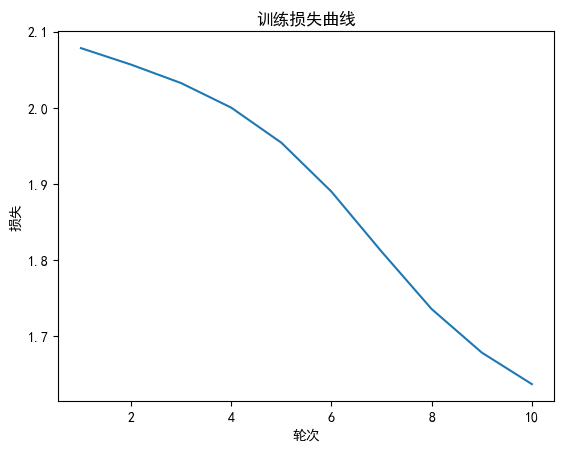

In [6]:
import torch.optim as optim

learning_rate = 1e-3
epochs = 1000
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(skipgram_model.parameters(),lr=learning_rate)

loss_valus = []

for epoch in range(epochs):
    loss_sum = 0
    for context,target in data:
        X = one_hot_encoding(target,word_to_idx).float().unsqueeze(0)
        y_true = torch.tensor([word_to_idx[context]],dtype=torch.long)
        y_pred = skipgram_model(X)
        loss = criterion(y_pred,y_true)
        # 累计损失
        loss_sum += loss.item()
        # 清空梯度
        optimizer.zero_grad() 
        # 反向传播
        loss.backward()
        # 更新参数
        optimizer.step()
    if (epoch+1) % 100 == 0:
        print(f"Epoch:{epoch+1},Loss:{loss_sum/len(data)}")
        loss_valus.append(loss_sum/len(data))

import matplotlib.pyplot as plt
plt.rcParams["font.family"] = ["SimHei"]
plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False
plt.plot(range(1, epochs // 100 + 1), loss_valus)
plt.title("训练损失曲线")
plt.xlabel("轮次")
plt.ylabel("损失")
plt.show()

获取词嵌入信息

In [7]:
for word,idx in word_to_idx.items():
    print(f"{word}:{skipgram_model.input_to_hidden.weight[:,idx].detach().numpy()}")

# print("\nSkip-Gram词嵌入:")
# for word, idx in word_to_idx.items(): # 输出每个单词的嵌入向量
#     print(f"{word}: \
#     {skipgram_model.input_to_hidden.weight[:, idx].detach().numpy()}")  

bird:[0.13780859 0.95557827]
Cat:[-0.57458043  0.88080996]
Lion:[-0.58681184  0.7206932 ]
is:[-0.63966423 -0.79437786]
Pidgin:[0.74503595 0.0970599 ]
Merlin:[0.500834   0.20361884]
Dog:[-0.68703645  0.76929146]
animal:[0.5540323 0.8301644]


In [8]:
print(skipgram_model.input_to_hidden.weight.shape)

torch.Size([2, 8])


生成词嵌入图像

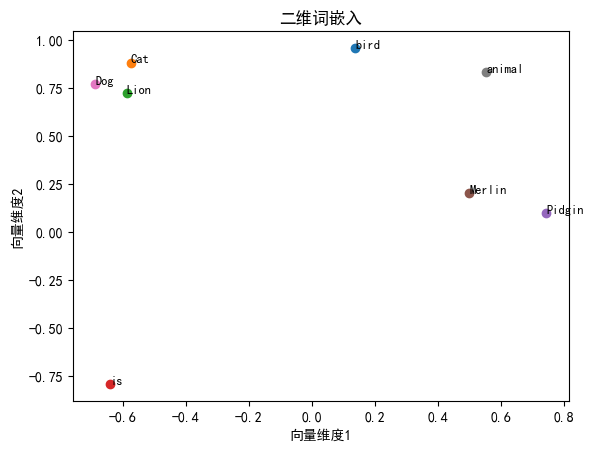

In [9]:
fig,ax = plt.subplots()
for word,idx in word_to_idx.items():
    vec = skipgram_model.input_to_hidden.weight[:,idx].detach().numpy()
    ax.scatter(vec[0],vec[1])
    ax.annotate(word,(vec[0],vec[1]),fontsize=9)
plt.title('二维词嵌入')
plt.xlabel('向量维度1')
plt.ylabel('向量维度2')
plt.show()